# Presentación

## Trabajo Práctico 1 : Reservas de Hotel

### Grupo 01 - Integrantes:
        Cabrera Rodríguez, Mateo 
        Gonzalez Alejo, Camila
        Bocanegra, Eduardo Martín

## Setup

### Instalar dependencias

In [274]:
pip install -r ../requirements.txt

4343.41s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


### Cargar bibliotecas

In [200]:
# Manipulacion de datos y funciones matemáticas
import pandas as pd
import numpy as np

# Visualizaciones
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# Entrenamiento y evaluacion de modelos
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Metricas para evaluar modelos
from sklearn import metrics

### Cargar Dataset

In [201]:
hoteles_ds = pd.read_csv('../datasets/hotels_train.csv')
hoteles_test_ds = pd.read_csv('../datasets/hotels_test.csv')
hoteles_ds_copy = hoteles_ds.copy()

## Checkpoint 1

### Exploración inicial de datos

In [276]:
print(hoteles_ds.shape)
hoteles_ds.head(n=2)

(61913, 32)


,hotel,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,...,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status_date,id,is_canceled
0,City Hotel,49,2016,September,37,5,1,2,1,0.0,...,9.0,NaN,0,Transient,115.5,0,1,2016-08-25,7aa4cc6b-b92c-4061-b21d-4f9e0cac4689,1
1,Resort Hotel,4,2015,October,44,31,0,1,2,0.0,...,NaN,NaN,0,Transient,42.0,1,0,2015-11-01,b1428f80-c56c-4ae4-91a9-6962edae08b1,0


Arreglo columnas dtype

In [202]:
# Separamos variables categoricas y numericas
# Vamos a tomar las categoricas como strings y las numericas como int o float

# Esta informacion la sacamos del paper del dataset
categoric_variables = ['agent', 'arrival_date_month', 'assigned_room_type', 'company', 'country', 'customer_type', 'deposit_type', 'distribution_channel', 'hotel', 'is_repeated_guest', 'market_segment', 'meal', 'reservation_status_date', 'reserved_room_type']
int_variables = ['adults', 'arrival_date_day_of_month', 'arrival_date_week_number', 'arrival_date_year', 'babies', 'booking_changes', 'children', 'days_in_waiting_list', 'lead_time', 'previous_bookings_not_canceled', 'previous_cancellations', 'required_car_parking_spaces', 'stays_in_weekend_nights', 'stays_in_week_nights', 'total_of_special_requests']
float_variables = ['ad']


def isfloat(value):
    try:
        float(value)
        return True
    except:
        return False

def parse_columns(df):
    # Vamos a convertir todas las columnas con datos categoricos a tipo 'string'
    # y vamos a eliminar los datos con coma que no tienen sentido para este tipo de variables
    df[categoric_variables] = df[categoric_variables].astype('string')
    for col in categoric_variables:
        #values = df[col].str.split('.')
        values = df[col]
        # Elimina la parte flotante. Pone como NaN los vacios
        for i, value in enumerate(values):
            if isfloat(value):
                values[i] = str(int(float(value)))
                continue
            if str(value) == str(pd.NA):
                continue

        
        df[col] = values
    df[categoric_variables] = df[categoric_variables].astype('string')


parse_columns(hoteles_ds)
parse_columns(hoteles_test_ds)
hoteles_ds_copy = hoteles_ds.copy()
print('Variables Categoricas: ', categoric_variables)
print('Variables Enteras: ', int_variables)
print('Variables Floatantes: ', float_variables)

Variables Categoricas:  ['agent', 'arrival_date_month', 'assigned_room_type', 'company', 'country', 'customer_type', 'deposit_type', 'distribution_channel', 'hotel', 'is_repeated_guest', 'market_segment', 'meal', 'reservation_status_date', 'reserved_room_type']
Variables Enteras:  ['adults', 'arrival_date_day_of_month', 'arrival_date_week_number', 'arrival_date_year', 'babies', 'booking_changes', 'children', 'days_in_waiting_list', 'lead_time', 'previous_bookings_not_canceled', 'previous_cancellations', 'required_car_parking_spaces', 'stays_in_weekend_nights', 'stays_in_week_nights', 'total_of_special_requests']
Variables Floatantes:  ['ad']


### Visualización de los datos

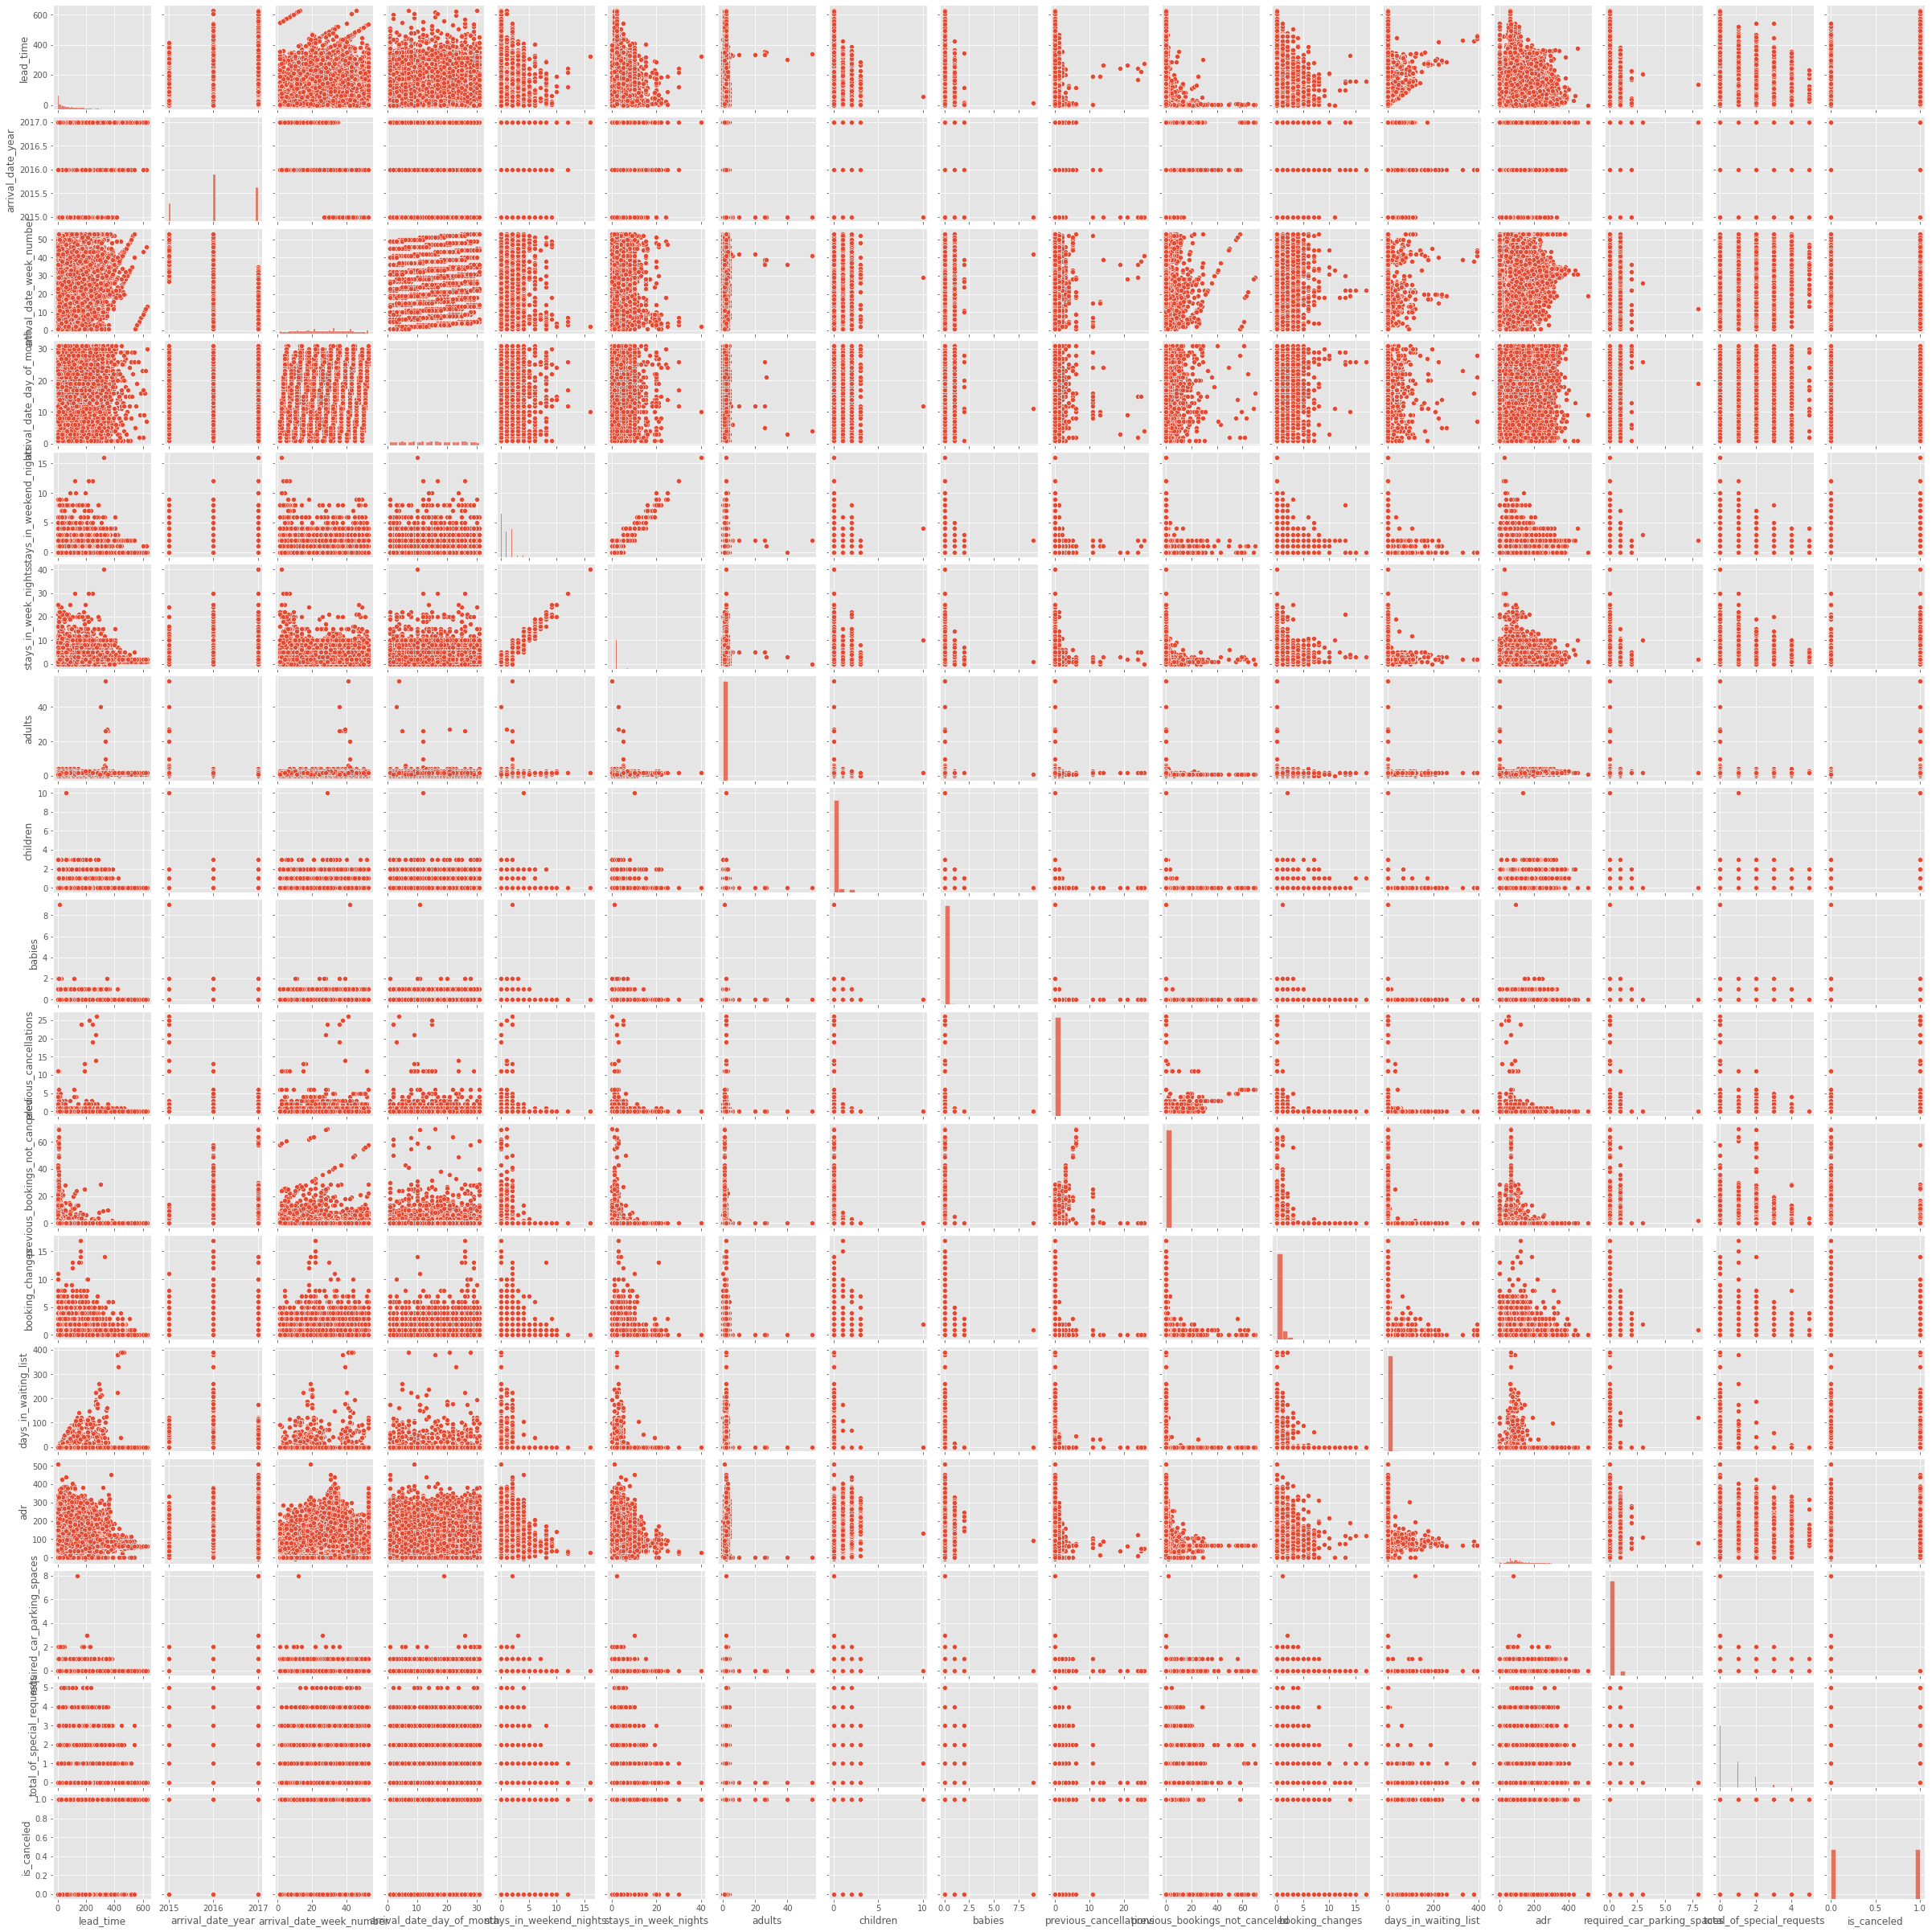

In [166]:
sns.pairplot(hoteles_ds, height=2)

Cálculo de correlaciones

<AxesSubplot:>

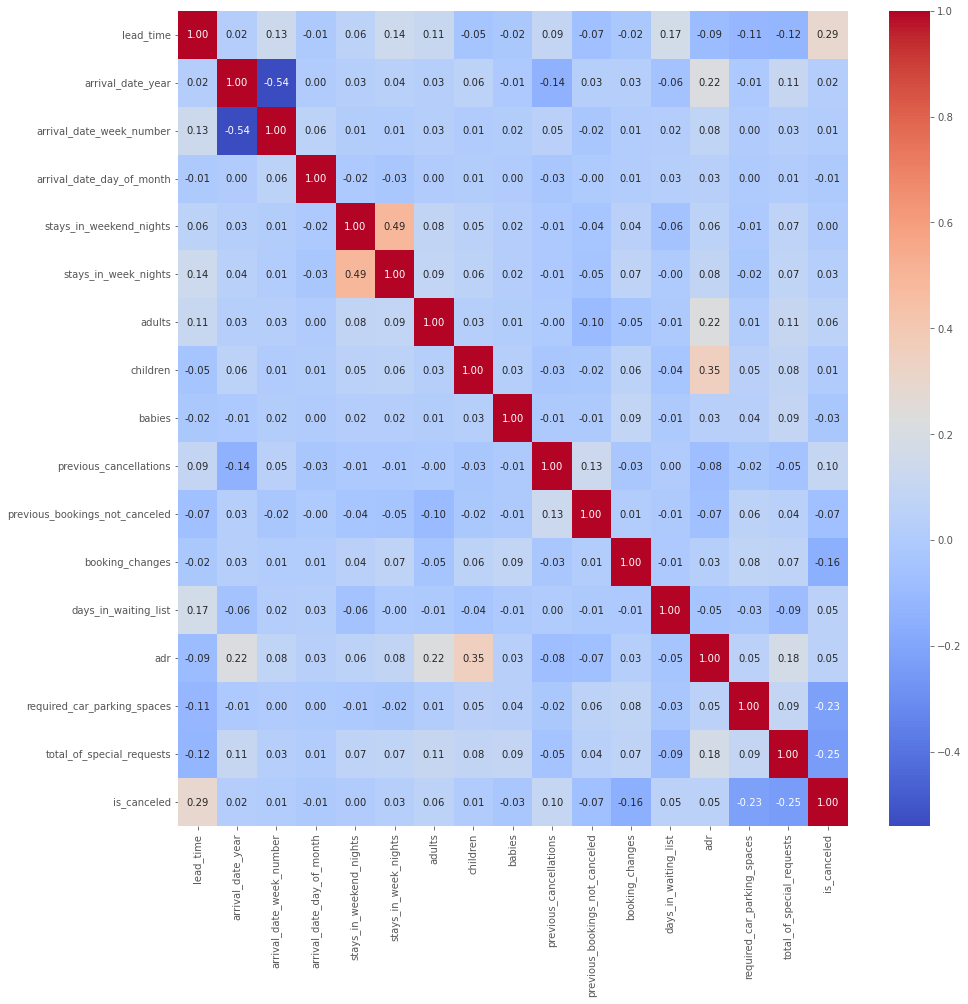

In [165]:
# Calculamos el indice de correlacion de pearson para todas las variables (numericas) y graficamos con un heatmap
corr = hoteles_ds.corr(method='pearson', numeric_only=True)
plt.figure(figsize=(15,15))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm')


<AxesSubplot:>

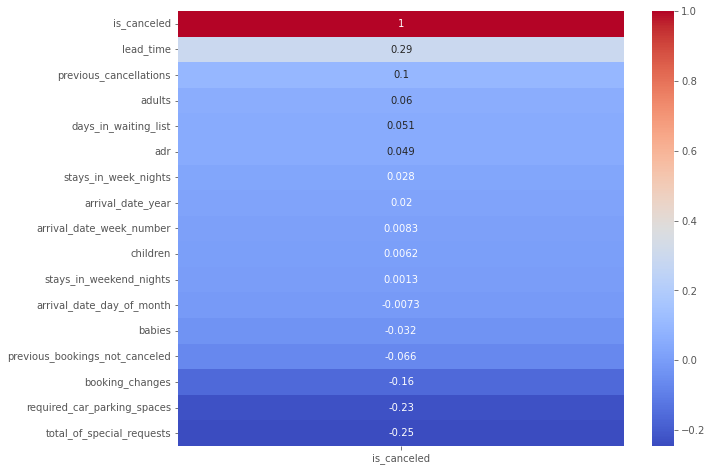

In [211]:
# Analizamos la relacion entre las variables y el target
plt.figure(figsize=(10,8))
sns.heatmap(hoteles_ds.corr(numeric_only=True)[['is_canceled']].sort_values(by='is_canceled', ascending=False), annot=True, cmap='coolwarm')

Relación entre el tiempo de anticipación y el estado de cancelación

<AxesSubplot:xlabel='is_canceled', ylabel='lead_time'>

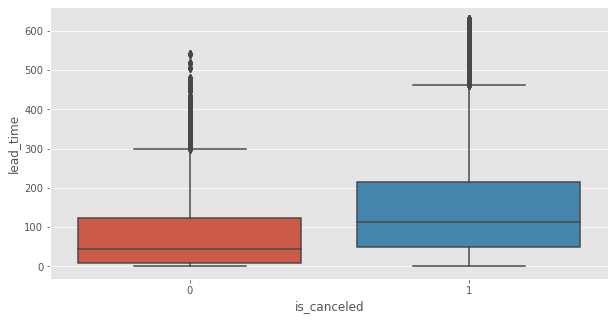

In [212]:
plt.figure(figsize=(10,5))
sns.boxplot(x='is_canceled', y='lead_time', data=hoteles_ds)

Relacion entre la cantidad de pedidos especiales y el estado de la cancelación

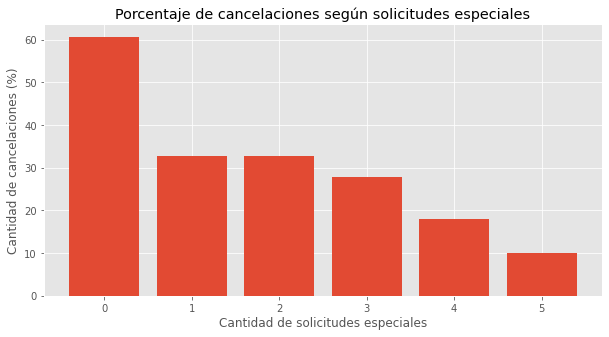

In [213]:
cancelations_by_amount_of_special_requests = hoteles_ds.groupby('total_of_special_requests')['is_canceled'].sum()
reservations_by_amount_of_special_requests = hoteles_ds.groupby('total_of_special_requests')['hotel'].count()
x = [i for i in range(0,6)]
y = [cancelations_by_amount_of_special_requests[i]/reservations_by_amount_of_special_requests[i]*100 for i in x]

plt.figure(figsize=(10,5))
plt.bar(x, y)
plt.title('Porcentaje de cancelaciones según solicitudes especiales')
plt.xlabel('Cantidad de solicitudes especiales')
plt.ylabel('Cantidad de cancelaciones (%)')
plt.show()

Relacion entre la cantidad de lugares en el estacionamiento y el estado de la cancelación

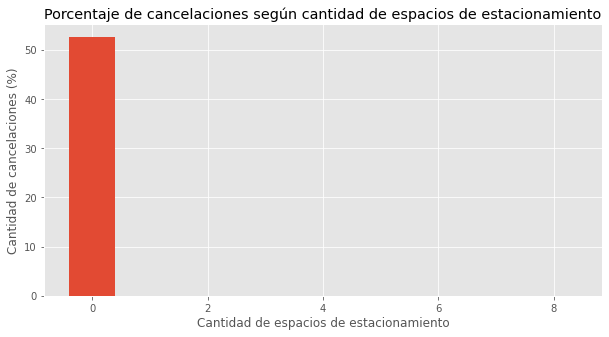

In [214]:
cancelations_by_amount_of_special_requests = hoteles_ds.groupby('required_car_parking_spaces')['is_canceled'].sum()
reservations_by_amount_of_special_requests = hoteles_ds.groupby('required_car_parking_spaces')['hotel'].count()
x = [0,1,2,3,8]
y = [cancelations_by_amount_of_special_requests[i]/reservations_by_amount_of_special_requests[i]*100 for i in x]

plt.figure(figsize=(10,5))
plt.bar(x, y)
plt.title('Porcentaje de cancelaciones según cantidad de espacios de estacionamiento')
plt.xlabel('Cantidad de espacios de estacionamiento')
plt.ylabel('Cantidad de cancelaciones (%)')
plt.show()

Cantidad de cancelaciones por mes, de cada hotel


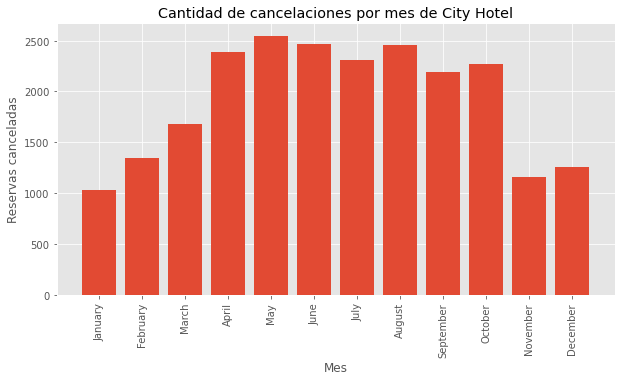

In [215]:
cancelations_by_month = hoteles_ds[hoteles_ds['hotel'] == 'City Hotel'].groupby('arrival_date_month')['is_canceled'].sum()
x = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
y = [cancelations_by_month[mes] for mes in x]

plt.figure(figsize=(10,5))
plt.bar(x, y)
plt.xticks(rotation=90)
plt.title('Cantidad de cancelaciones por mes de City Hotel')
plt.xlabel('Mes')
plt.ylabel('Reservas canceladas')
plt.show()

Vemos que hay una grande variación, pero tal vez se debe al número de reservas por cada mes. Para eliminar esa variable del gráfico, vamos a graficar el porcentaje de las reservas que fueron canceladas cada mes:

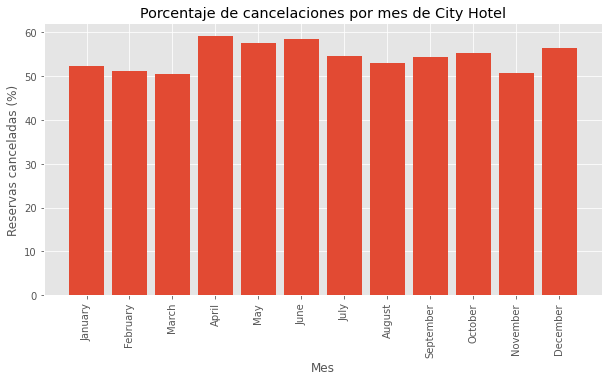

In [216]:
reservations_by_month = hoteles_ds[hoteles_ds['hotel'] == 'City Hotel'].groupby('arrival_date_month')['hotel'].count()
x = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
y = [cancelations_by_month[mes]/reservations_by_month[mes]*100 for mes in x]

plt.figure(figsize=(10,5))
plt.bar(x, y)
plt.xticks(rotation=90)
plt.title('Porcentaje de cancelaciones por mes de City Hotel')
plt.xlabel('Mes')
plt.ylabel('Reservas canceladas (%)')
plt.show()

Hacemos lo mismo para el Resort Hotel:

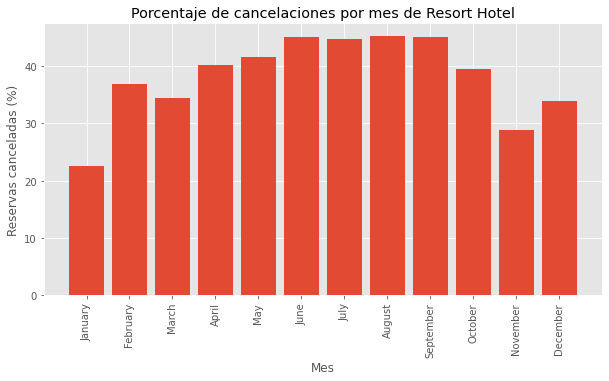

In [217]:
cancelations_by_month = hoteles_ds[hoteles_ds['hotel'] == 'Resort Hotel'].groupby('arrival_date_month')['is_canceled'].sum()
reservations_by_month = hoteles_ds[hoteles_ds['hotel'] == 'Resort Hotel'].groupby('arrival_date_month')['hotel'].count()
x = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
y = [cancelations_by_month[mes]/reservations_by_month[mes]*100 for mes in x]

plt.figure(figsize=(10,5))
plt.bar(x, y)
plt.xticks(rotation=90)
plt.title('Porcentaje de cancelaciones por mes de Resort Hotel')
plt.xlabel('Mes')
plt.ylabel('Reservas canceladas (%)')
plt.show()

Porcentaje de cancelaciones por año

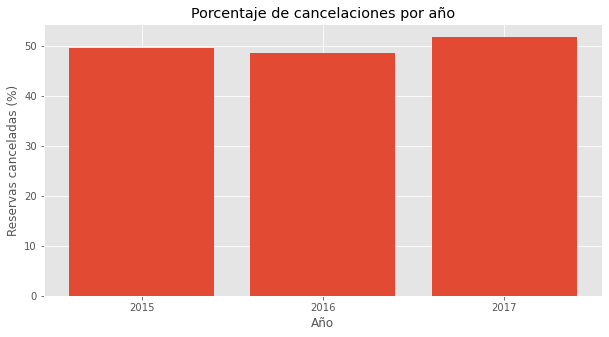

In [218]:

cancelations_by_year = hoteles_ds.groupby('arrival_date_year')['is_canceled'].sum()
reservations_by_year = hoteles_ds.groupby('arrival_date_year')['hotel'].count()
x = ['2015', '2016', '2017']
y = [cancelations_by_year[int(anio)]/reservations_by_year[int(anio)]*100 for anio in x]

plt.figure(figsize=(10,5))
plt.bar(x, y)
plt.title('Porcentaje de cancelaciones por año')
plt.xlabel('Año')
plt.ylabel('Reservas canceladas (%)')
plt.show()

Los 30 paises que mas cancelan

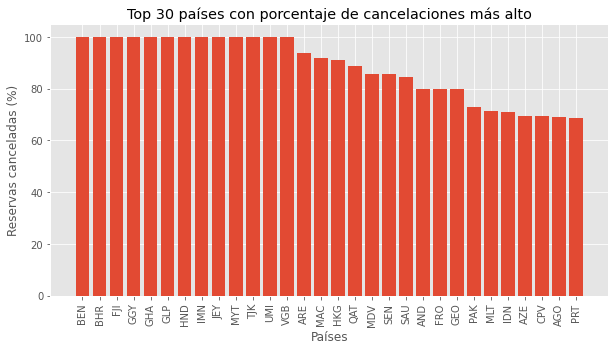

In [219]:
cancelations_by_country = hoteles_ds.groupby('country')['is_canceled'].sum().sort_values(ascending=False)
reservations_by_country = hoteles_ds.groupby('country')['hotel'].count().sort_values(ascending=False)
porcentaje_cancelaciones = cancelations_by_country/reservations_by_country*100
porcentaje_cancelaciones = sorted(porcentaje_cancelaciones.items(), key=lambda x: x[1], reverse=True)
#grafico las 30 mas altas
x = [pais[0] for pais in porcentaje_cancelaciones[:30]]
y = [pais[1] for pais in porcentaje_cancelaciones[:30]]

plt.figure(figsize=(10,5))
plt.bar(x, y)
plt.xticks(rotation=90)
plt.title('Top 30 países con porcentaje de cancelaciones más alto')
plt.xlabel('Países')
plt.ylabel('Reservas canceladas (%)')
plt.show()


Cancelaciones según cantidad de bebes

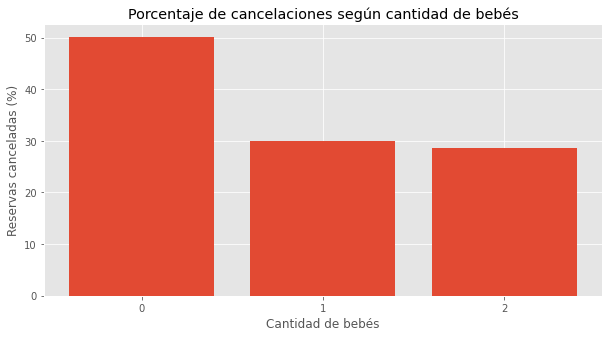

In [220]:
babies_df = hoteles_ds['babies']
cancel_babies = hoteles_ds[hoteles_ds['is_canceled'] == 1]['babies'].value_counts()
reservations_babies = hoteles_ds['babies'].value_counts()

x = ['0', '1', '2']
y = [cancel_babies[i]/reservations_babies[i]*100 for i, _ in enumerate(x)]

plt.figure(figsize=(10,5))
plt.bar(x, y)
plt.title('Porcentaje de cancelaciones según cantidad de bebés')
plt.xlabel('Cantidad de bebés')
plt.ylabel('Reservas canceladas (%)')
plt.show()


### Datos Faltantes

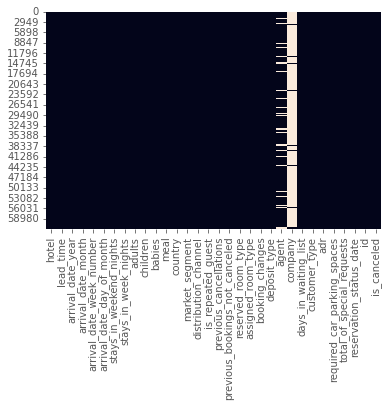

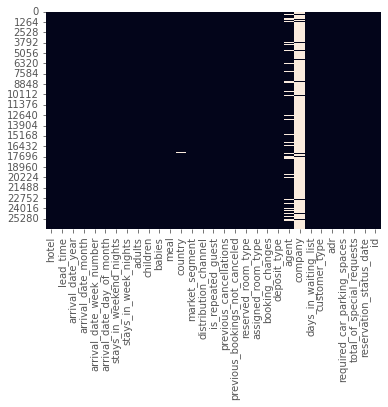

In [186]:
sns.heatmap(hoteles_ds.isnull(), cbar=False)
plt.show()
sns.heatmap(hoteles_test_ds.isnull(), cbar=False)
plt.show()

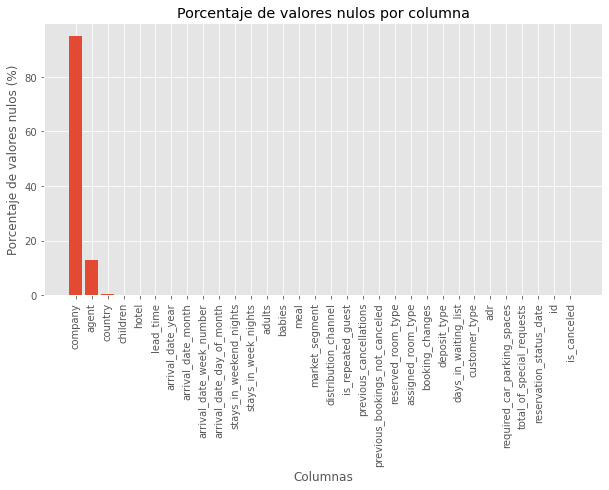

In [187]:
nulls_by_column = hoteles_ds.isnull().mean()*100
nulls_by_column = sorted(nulls_by_column.items(), key=lambda x: x[1], reverse=True)
x = [columna[0] for columna in nulls_by_column]
y = [columna[1] for columna in nulls_by_column]

plt.figure(figsize=(10,5))
plt.bar(x, y)
plt.xticks(rotation=90)
plt.title('Porcentaje de valores nulos por columna')
plt.xlabel('Columnas')
plt.ylabel('Porcentaje de valores nulos (%)')
plt.show()

Observacion del numero exacto de nulos por columna


In [164]:
vars_with_na = [var for var in hoteles_ds.columns if hoteles_ds[var].isnull().sum() > 0]

for var in vars_with_na:
    print(f"{var}: {hoteles_ds[var].isnull().sum()} datos faltantes ({np.round(hoteles_ds[var].isnull().mean() * 100, 2)}%)")

country: 221 datos faltantes (0.36%)
agent: 7890 datos faltantes (12.74%)
company: 58761 datos faltantes (94.91%)


Pruebas con datos faltantes

In [203]:
#hoteles_ds = hoteles_ds_copy.copy()
#hoteles_ds.dropna(subset=['children', 'country'], inplace=True)

# Nos dimos cuenta que eliminar las filas con 'country' vacío,
# baja la precisión del modelo, por lo que decidimos dejarlas como estan
#hoteles_ds.dropna(subset=['children'], inplace=True)

# Probamos reemplazar los nulos de 'children' por 0
def fix_children(df):
    # Convertimos children a int. No tiene sentido que sea float
    df['children'].fillna(0, inplace=True)
    df['children'] = df['children'].astype('int64')
    
fix_children(hoteles_ds)
fix_children(hoteles_test_ds)


### Valores Atipicos

Chequeo cantidad de bebes

In [259]:
# Decidimos sacar las filas con 5 o más bebés.
# Había una sola reserva con 9 bebés. Asumimos valor atípico
# hoteles_ds = hoteles_ds[hoteles_ds['babies'] < 5]

Chequeo cantidad de niños

In [260]:
# Decidimos sacar las filas con 5 o más children.
# Había una sola reserva con 10 children. Asumimos valor atípico
# hoteles_ds = hoteles_ds[hoteles_ds['children'] < 5]

Chequeo cantidad de adultos

In [287]:
num_adults = hoteles_ds['adults'].value_counts()
num_adults

# Decidimos sacar las filas con 6 o más adultos.
# Asumimos valores atípicos. Las reservas estan todas canceladas
# hoteles_ds = hoteles_ds[hoteles_ds['adults'] < 6]

adults
2     46959
1     11549
3      3163
0       197
4        30
26        3
5         2
40        1
20        1
6         1
10        1
27        1
55        1
Name: count, dtype: int64

Reservas sin adultos

In [288]:
rooms_without_adults = hoteles_ds.loc[hoteles_ds['adults'] < 1]

print('Cantidad de reservas sin adultos: ', rooms_without_adults.shape[0], '(', round(rooms_without_adults.shape[0]/hoteles_ds.shape[0]*100, 2), '%)')

# Decidimos sacar las reservas que no tienen adultos.
# Asumimos que son errores de carga
# hoteles_ds = hoteles_ds[hoteles_ds['adults'] >= 1]

Cantidad de reservas sin adultos:  197 ( 0.32 %)


In [289]:
rooms_without_people = hoteles_ds.loc[(hoteles_ds['adults'] < 1) & (hoteles_ds['children'] < 1) & (hoteles_ds['babies'] < 1)]

print('Cantidad de reservas sin personas: ', rooms_without_people.shape[0], '(', round(rooms_without_people.shape[0]/hoteles_ds.shape[0]*100, 2), '%)')

# hoteles_ds = hoteles_ds[(hoteles_ds['adults'] >= 1) | (hoteles_ds['children'] >= 1) | (hoteles_ds['babies'] >= 1)]

Cantidad de reservas sin personas:  76 ( 0.12 %)


### Encodeo de strings

In [204]:
from sklearn import preprocessing


le = preprocessing.LabelEncoder()

def encode_columns(df):
    df.fillna(value="null", inplace=True)
    
    # Si meal es Undefined o vacío, reemplazamos por SC (dice el paper)
    df['meal'] = df['meal'].apply(lambda x: 'SC' if x in ['Undefined', 'null', ''] else x)
    # One Hot Encoding
    df = pd.get_dummies(df, columns=['assigned_room_type'], drop_first=True)
    df = pd.get_dummies(df, columns=['customer_type'], drop_first=True)
    df = pd.get_dummies(df, columns=['deposit_type'], drop_first=True)
    df = pd.get_dummies(df, columns=['distribution_channel'], drop_first=True)
    df = pd.get_dummies(df, columns=['hotel'], drop_first=True)
    df = pd.get_dummies(df, columns=['meal'], drop_first=True)    
    df = pd.get_dummies(df, columns=['reserved_room_type'], drop_first=True)

    # Label encoding
    df['arrival_date_month'] = le.fit_transform(df['arrival_date_month'])
    df['agent'] = le.fit_transform(df['agent'])
    df['company'] = le.fit_transform(df['company'])
    df['country'] = le.fit_transform(df['country'])
    df['id'] = le.fit_transform(df['id'])
    df['market_segment'] = le.fit_transform(df['market_segment'])
    df['is_repeated_guest'] = le.fit_transform(df['is_repeated_guest'])
    df['reservation_status_date'] = le.fit_transform(df['reservation_status_date'])

    return df


### Entrenamiento del modelo

In [206]:
TESTING=False

hoteles_train_ds = hoteles_ds.copy()
hoteles_test_test_ds = hoteles_test_ds.copy()
non_encoded_id_column_test = hoteles_test_test_ds['id']

# Encodeamos las columnas de nuestro dataset
hoteles_train_ds = encode_columns(hoteles_train_ds)
hoteles_test_test_ds = encode_columns(hoteles_test_test_ds)

# Añadimos las columnas que faltan en el dataset de testeo con valores = 0
# Estas columnas son las resultantes de hacer One Hot Encoding
# Está bien ponerles valor = 0 porque no hay ninguna reserva que tenga el dato presente
# Si hubiera alguna reserva con el dato, se agregaría automaticamente la columna al usar One Hot Encoding
for col in hoteles_train_ds.copy().drop('is_canceled', axis=1).columns:
    if col not in hoteles_test_test_ds.columns:
        hoteles_test_test_ds[col] = 0



# Nuestro dataset filtrado
x = hoteles_train_ds.copy().drop('is_canceled', axis=1)
y = hoteles_train_ds['is_canceled']

# Ordenamos las columnas para que ambos datasets coincidan
x = x.reindex(sorted(x.columns), axis=1)
hoteles_test_test_ds = hoteles_test_test_ds.reindex(sorted(hoteles_test_test_ds.columns), axis=1)

if TESTING:
    # Generamos un dataset de testeo para medir la precision del modelo.
    # En este paso se reduce el tamaño del dataset de entrenamiento, por lo que
    # solo lo usamos para probar, no para subir las predicciones.
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=73)
    lr = LogisticRegression()
    
    # Mostramos la info de precision
    lr.fit(x_train, y_train)
    y_pred = lr.predict(x_test)
    print(f"Precision: {accuracy_score(y_test, y_pred)}")

else:
    # Usamos el dataset completo para entrenar el modelo
    x_train = x
    y_train = y
    x_test = hoteles_test_test_ds.copy()

    lr = LogisticRegression()
    lr.fit(x_train, y_train)
    y_pred = lr.predict(x_test)

    # Generamos el archivo de predicciones
    predicts = pd.DataFrame({'id': non_encoded_id_column_test, 'is_canceled': y_pred})
    predicts.to_csv('../predicts.csv', index=False)


/home/martin/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


ValueError: 2